# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

**Описание данных:**

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг 1. Откроем файлы и изучим общую информацию.

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
pd.set_option('display.max_columns', 999)   

### Датасет calls

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.sort_values('duration', ascending=False)

,id,call_date,duration,user_id
95088,1241_44,2018-09-06,38.00,1241
178737,1446_22,2018-11-07,37.35,1446
5865,1017_61,2018-11-13,36.47,1017
39777,1099_150,2018-08-14,36.12,1099
60889,1153_135,2018-11-16,35.95,1153
...,...,...,...,...
45132,1113_548,2018-12-16,0.00,1113
144950,1365_82,2018-11-25,0.00,1365
144952,1365_84,2018-12-20,0.00,1365
45127,1113_543,2018-11-21,0.00,1113


Не похоже, что в датасете имеются вбросы. 38 минут разговора - стандартный разговор друзей, которые долго не видели друг друга.

Датасет хранит информацию о звонках, которые совершили 500 пользователей за 2018 год. Пропущенных значений нет. Вбросов нет.
- **call_date** указан не в datetime формате
- Значения столбца **duration**, в которых указано значение 0 - звонки, которые не были приняты

### Датасет internet

In [5]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Вероятно, значения столбца **Unnamed: 0** дублируют индексы.

Найдем уникальные значения этого столбца.

In [6]:
internet['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 149393, 149394, 149395])

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Действительно, последнее уникальное значение 149395, а всего значений 149396 (учитывая нулевое)

- значения столбца **session_date** представлены не в datetime формате

In [8]:
internet.sort_values('mb_used', ascending=False)

,Unnamed: 0,id,mb_used,session_date,user_id
137493,137493,1461_9,1724.83,2018-11-28,1461
119156,119156,1402_191,1702.75,2018-10-26,1402
7063,7063,1024_118,1651.55,2018-11-15,1024
103480,103480,1348_138,1651.25,2018-10-31,1348
140299,140299,1471_182,1623.92,2018-07-29,1471
...,...,...,...,...,...
118555,118555,1400_266,0.00,2018-10-14,1400
112336,112336,1380_465,0.00,2018-08-06,1380
118557,118557,1400_268,0.00,2018-12-27,1400
15836,15836,1055_294,0.00,2018-09-16,1055


1724 мегабайта за сессию не похоже на вброс. Возможно, кто-то начал смотреть видео Дудя в 720p, забыв выключить мобильный интернет. Вот и сжег столько трафика.  

В датасете зранится информация о сессиях пользователей в интеренете: дата сессии и количество потраченных мегабайт.
Пропущенных значений нет. Вбросов тоже нет.
- значения столбца **session_date** следует перевести в datetime формат.

### Датасет messages

In [9]:
messages = pd.read_csv('/datasets/messages.csv')
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Датасет содержит информацию о сообщениях, отправленных пользователями за 2018 год.
- Значения message_date следует перевести в формат, соответствующий дате

### Датасет tariffs

In [11]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Датасет содержит информацию о тарифах - "smart" и "ultra"
- значение стобца **reg_date** в datetime формат

### Датасет users

In [13]:
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
users.sort_values('age')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
77,1077,18,NaN,Москва,Марица,Кольцова,2018-10-23,smart
204,1204,18,NaN,Москва,Мирослава,Лазарева,2018-01-04,smart
270,1270,18,NaN,Нижневартовск,Мальвина,Вешнякова,2018-07-01,ultra
268,1268,18,NaN,Москва,Трофим,Трошин,2018-05-28,smart
473,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra
...,...,...,...,...,...,...,...,...
254,1254,75,2018-08-17,Москва,Александра,Сухарева,2018-01-04,ultra
436,1436,75,NaN,Москва,Радим,Ерофеев,2018-04-04,ultra
478,1478,75,NaN,Грозный,Таира,Константинова,2018-07-16,smart
177,1177,75,NaN,Новосибирск,Лолита,Аничкина,2018-06-19,smart


Возраст от 17 до 75. Кощеев Бессмертных нет.



Датасет содержит информацию о пользователях - 500 человек, которые совершали звонки в течение 2018 года.
- в данных содержатся пропущенные значения в столбце **churn_date** 
- **reg_date** перевести в datetime формат

### Вывод

Мы описали, что содержится в каждом из датасетов, а также выделили проблемы, которые стоит исправить. Помимо описанных проблем, стоит "склеить" данные в единый датасет.

## Шаг 2. Предобработка данных.

В датасете **internet** дропнем столбец, дублирующий индексы

In [16]:
internet.drop(columns='Unnamed: 0', inplace=True)

In [17]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Пропущенные значения столбца **churn_date** заменим на нули

In [18]:
users.fillna('0', inplace=True)

In [19]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,0,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,0,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,0,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Добавим столбец **month** в датасет **calls**

In [20]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') 
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Добавим столбец **month** в датасет **messages**

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Добавим столбец **month** в датасет **internet**

In [22]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d') 
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Сгруппируем данные столбца **calls** по **user_id** и **month**

In [23]:
calls_per_person = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
calls_per_person.head()

sum    count
              duration duration
user_id month                  
1000    5       150.06       22
        6       158.90       43
        7       318.80       47
        8       389.87       52
        9       440.14       58

Изменим названия столбцов

In [24]:
calls_per_person.columns = ['sum_calls', 'count_calls']
calls_per_person

sum_calls  count_calls
user_id month                        
1000    5         150.06           22
        6         158.90           43
        7         318.80           47
        8         389.87           52
        9         440.14           58
...                  ...          ...
1498    10        232.63           41
1499    9          64.65            9
        10        429.91           68
        11        576.50           74
        12        465.16           69

[3174 rows x 2 columns]

Сгруппируем данные столбца **messages** по **user_id** и **month**

In [25]:
messages_per_person = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_per_person.head()

message_date
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57

Изменим названия столбца

In [26]:
messages_per_person.columns = ['number_messages']
messages_per_person

number_messages
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57
...                        ...
1498    10                  42
1499    9                   11
        10                  48
        11                  59
        12                  66

[2717 rows x 1 columns]

Сгруппируем данные столбца **internet** по **user_id** и **month**

In [27]:
internet_spent = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_spent

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

Используя метод **merge** "склеим" датасеты в один большой датасет **users_data**. Выполним "reset_index()", чтобы в будущем можно было обращаться к столбцу **month**

In [28]:
users_data = (calls_per_person
              .merge(messages_per_person, on=['user_id', 'month'], how='left')
              .merge(internet_spent, on=['user_id', 'month'], how='left')
             ).reset_index()
users_data

,user_id,month,sum_calls,count_calls,number_messages,mb_used
0,1000,5,150.06,22,22.0,2253.49
1,1000,6,158.90,43,60.0,23233.77
2,1000,7,318.80,47,75.0,14003.64
3,1000,8,389.87,52,81.0,14055.93
4,1000,9,440.14,58,57.0,14568.91
...,...,...,...,...,...,...
3169,1498,10,232.63,41,42.0,20579.36
3170,1499,9,64.65,9,11.0,1845.75
3171,1499,10,429.91,68,48.0,17788.51
3172,1499,11,576.50,74,59.0,17963.31


Сделаем наш большой датасет еще более большим: добавим в него информацию о пользователях, содержащующся в датасете **users**

In [29]:
users_data = users.merge(users_data, on='user_id', how='left')
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_calls,count_calls,number_messages,mb_used
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,150.06,22.0,22.0,2253.49
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,158.90,43.0,60.0,23233.77
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,318.80,47.0,75.0,14003.64
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,389.87,52.0,81.0,14055.93
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,440.14,58.0,57.0,14568.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10.0,232.63,41.0,42.0,20579.36
3178,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9.0,64.65,9.0,11.0,1845.75
3179,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,10.0,429.91,68.0,48.0,17788.51
3180,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,11.0,576.50,74.0,59.0,17963.31


В датасете **users_data** хранится практически вся информация, не хватает только датасета **tariffs**

In [30]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Поменяем название столбца **tariff_name** на **tariff**

In [31]:
tariffs.columns = ['messages_included',	'mb_per_month_included', 'minutes_included',
                   'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute','tariff'
                  ]

In [32]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Добавим данный датасет к **users_data**

In [33]:
users_data = users_data.merge(tariffs, on='tariff', how='left')
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_calls,count_calls,number_messages,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,150.06,22.0,22.0,2253.49,1000,30720,3000,1950,150,1,1
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,158.90,43.0,60.0,23233.77,1000,30720,3000,1950,150,1,1
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,318.80,47.0,75.0,14003.64,1000,30720,3000,1950,150,1,1
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,389.87,52.0,81.0,14055.93,1000,30720,3000,1950,150,1,1
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,440.14,58.0,57.0,14568.91,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10.0,232.63,41.0,42.0,20579.36,50,15360,500,550,200,3,3
3178,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9.0,64.65,9.0,11.0,1845.75,50,15360,500,550,200,3,3
3179,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,10.0,429.91,68.0,48.0,17788.51,50,15360,500,550,200,3,3
3180,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,11.0,576.50,74.0,59.0,17963.31,50,15360,500,550,200,3,3


Проверим: содержатся ли в таблице **users_data** пропузенные значения

In [34]:
users_data.isna().sum()

user_id                    0
age                        0
churn_date                 0
city                       0
first_name                 0
last_name                  0
reg_date                   0
tariff                     0
month                      8
sum_calls                  8
count_calls                8
number_messages          504
mb_used                   19
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

Вероятно, 504 человека не отправляли сообщений, 19 не использовали интернет и 8 не звонили. Этих значений недостаточно, чтобы существенно повлиять на результаты исследования.
Заменим на нули пропущенные значения в столбцах: **number_messages**, **mb_used**, **count_calls**, **sum_calls**

Дропнем 8 пропущенных значений в столбце **month**, т.к не очень понятна природа их появления, да и 8 значений это "капля в море"

In [35]:
users_data['number_messages'].fillna(0, inplace=True)
users_data['mb_used'].fillna(0, inplace=True)
users_data['count_calls'].fillna(0, inplace=True)
users_data['sum_calls'].fillna(0, inplace=True)
users_data.dropna(subset=['month'], inplace=True)

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
понятно)
<br>
</font>

In [36]:
users_data.isna().sum()

user_id                  0
age                      0
churn_date               0
city                     0
first_name               0
last_name                0
reg_date                 0
tariff                   0
month                    0
sum_calls                0
count_calls              0
number_messages          0
mb_used                  0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

In [37]:
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_calls,count_calls,number_messages,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,150.06,22.0,22.0,2253.49,1000,30720,3000,1950,150,1,1
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,158.90,43.0,60.0,23233.77,1000,30720,3000,1950,150,1,1
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,318.80,47.0,75.0,14003.64,1000,30720,3000,1950,150,1,1
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,389.87,52.0,81.0,14055.93,1000,30720,3000,1950,150,1,1
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,440.14,58.0,57.0,14568.91,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10.0,232.63,41.0,42.0,20579.36,50,15360,500,550,200,3,3
3178,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9.0,64.65,9.0,11.0,1845.75,50,15360,500,550,200,3,3
3179,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,10.0,429.91,68.0,48.0,17788.51,50,15360,500,550,200,3,3
3180,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,11.0,576.50,74.0,59.0,17963.31,50,15360,500,550,200,3,3


Приведем столбцы к нужному типу

In [38]:
users_data['month'] = users_data['month'].astype('int')
users_data['count_calls'] = users_data['count_calls'].astype('int')
users_data['number_messages'] = users_data['number_messages'].astype('int')


In [39]:
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_calls,count_calls,number_messages,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,150.06,22,22,2253.49,1000,30720,3000,1950,150,1,1
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,158.90,43,60,23233.77,1000,30720,3000,1950,150,1,1
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,318.80,47,75,14003.64,1000,30720,3000,1950,150,1,1
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,389.87,52,81,14055.93,1000,30720,3000,1950,150,1,1
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,440.14,58,57,14568.91,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,232.63,41,42,20579.36,50,15360,500,550,200,3,3
3178,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9,64.65,9,11,1845.75,50,15360,500,550,200,3,3
3179,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,10,429.91,68,48,17788.51,50,15360,500,550,200,3,3
3180,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,11,576.50,74,59,17963.31,50,15360,500,550,200,3,3


Запишем функцию **revenue**, которая будет подсчитывать доход с абонента.

Функция проверяет, есть ли переизбыток по потраченным минутам/сообщениям/интернету, а далее умножает переизбыток на стоимость переизбыточной минуты/сообщения/гигабайта интернета. После чего складывает доход с минут, сообщений и гигабайт

При подсчете интернета есть небольшая особенность: нужно перевести мегабайты в гигабайты (поэтому делим на 1024)

По условию сказано "«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.", поэтому, используя функцию **ceil** из библиотеки **math**, округлим полученные значения вверх.

В конце функция **revenue** добавляет к выручке (с переизбыточных значений) ежемесячный платеж по тарифу.

Будем передавать значения в функции построчно, используя метод **apply** с значением аттрибута **axis=1**. В каждой строке указан месяц, поэтому у нас производится подсчет с учетом месяцев.

In [40]:
def revenue(x):
    revenue = 0
    if x['minutes_included'] < x['sum_calls']:                                    
        revenue += math.ceil((x['sum_calls'] - x['minutes_included']) * x['rub_per_minute'])
    if x['messages_included'] < x['number_messages']:                             
        revenue += math.ceil((x['number_messages'] - x['messages_included']) * x['rub_per_message']) 
    if x['mb_per_month_included'] < x['mb_used']:
        revenue += math.ceil(((x['mb_used'] - x['mb_per_month_included']) / 1024) * x['rub_per_gb']) 
    return revenue + x['rub_monthly_fee']


users_data['revenue'] = users_data.apply(revenue, axis=1)
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_calls,count_calls,number_messages,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,150.06,22,22,2253.49,1000,30720,3000,1950,150,1,1,1950
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,158.90,43,60,23233.77,1000,30720,3000,1950,150,1,1,1950
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,318.80,47,75,14003.64,1000,30720,3000,1950,150,1,1,1950
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,389.87,52,81,14055.93,1000,30720,3000,1950,150,1,1,1950
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,440.14,58,57,14568.91,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,232.63,41,42,20579.36,50,15360,500,550,200,3,3,1570
3178,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9,64.65,9,11,1845.75,50,15360,500,550,200,3,3,550
3179,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,10,429.91,68,48,17788.51,50,15360,500,550,200,3,3,1025
3180,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,11,576.50,74,59,17963.31,50,15360,500,550,200,3,3,1316


### Вывод

В результат были предобработаны данные, которые, в последствии, были представлены в сводной таблице **users_data**

## Шаг 3. Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### Сколько минут разговора требуется пользователям в месяц?

Для пользователей тарифа "smart"

In [41]:
smart_users_calls = (users_data
                     .query('tariff == "smart"')
                     .groupby('month')['sum_calls']
                     .mean()
                    )
smart_users_calls

month
1     193.042353
2     282.963448
3     367.877143
4     346.222589
5     365.214752
6     375.481595
7     385.498557
8     399.592179
9     406.081081
10    403.646416
11    411.889810
12    453.041071
Name: sum_calls, dtype: float64

In [42]:
smart_users_calls.mean()

365.8792496118162

С каждым месяцев среднее арифметическое минут растет. Это логично, т.к количество пользователей растет каждый месяц (прибвляются,чаще всего, активные пользователи), а следовательно и среднее арифметическое подрастает.

Посчитаем дисперсию и стандартное отклонение, т.к у нас не генеральная совокупность, то воспользуемся формулой для расчета дисперсии для выборки

In [43]:
np.var(smart_users_calls, ddof=1)

4682.620477032994

In [44]:
np.sqrt(np.var(smart_users_calls, ddof=1))

68.42967541230189

Получили, что среднее отклонение тарифа **smart** - 68 минут

Для пользователей тарифа "ultra"

In [45]:
ultra_users_calls = (users_data
                     .query('tariff == "ultra"')
                     .groupby('month')['sum_calls']
                     .mean()
                    )
ultra_users_calls

month
1     404.777778
2     280.570833
3     462.359730
4     448.188491
5     504.304531
6     469.706296
7     532.818409
8     500.651068
9     527.460901
10    549.152373
11    530.704961
12    580.510000
Name: sum_calls, dtype: float64

Здесь уже не прослеживается настолько линейный рост, как в предыдущей задаче, но все равно, за 12 месяцев среднее значение выросло
Посчитаем среднее

In [46]:
ultra_users_calls.mean()

482.60044758565135

Посчитаем вариацию для выборки

In [47]:
np.var(ultra_users_calls, ddof=1)

6390.285552292619

In [48]:
np.sqrt(np.var(ultra_users_calls, ddof=1))

79.93926164465506

Стандартное отклонение тарифа **ultra** 80

Отклонение в тарифе **ultra** больше, чем в **smart**. Посмотрим на график:

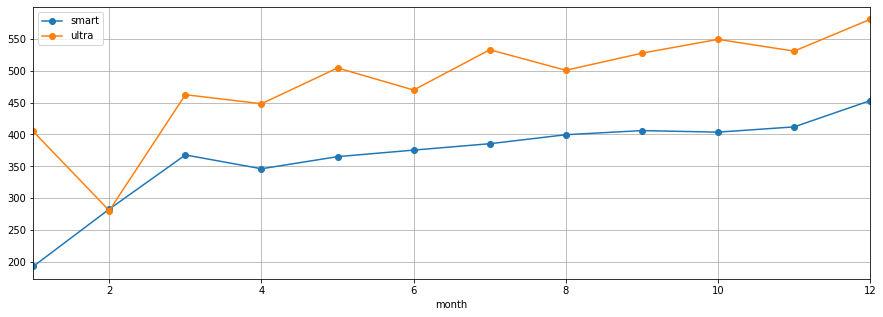

In [49]:
ax = (smart_users_calls
 .plot(style='o-', figsize=(15,5), grid=True)
 )
(ultra_users_calls
 .plot(style='o-', figsize=(15,5), grid=True, ax=ax, )
 )
plt.legend(['smart', 'ultra'])

График, соответствующий тарифу **smart** более пологий, чем у тарифа **ultra**, это еще одно объяснение того, почему среднее отклонение у тарифа **ultra** выше, чем у **smart**

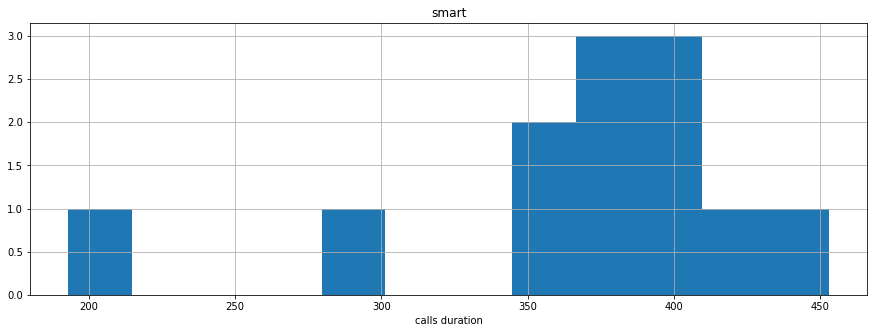

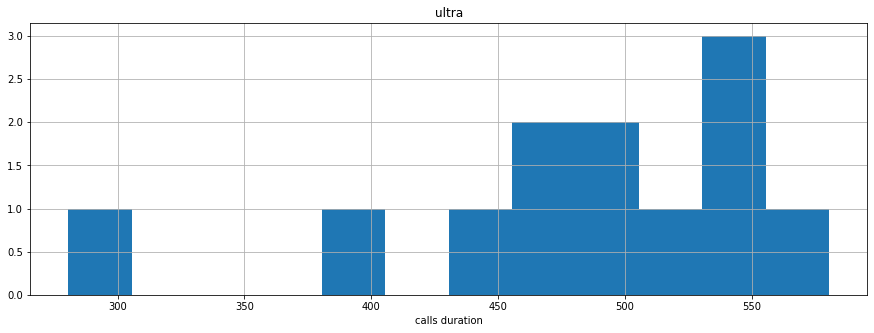

In [50]:
(smart_users_calls
     .hist(figsize=(15,5), bins=12)
)
plt.title('smart')
plt.xlabel('calls duration')
plt.show()
(ultra_users_calls
     .hist(figsize=(15,5), bins=12)
)
plt.title('ultra')
plt.xlabel('calls duration')
plt.show()

В тарифк **smart** чаще всего укладываются в 400 минут в месяц, в тарифе **ultra** же примерно 525

Данных не много (данные о 12 месяцах), поэтому ЦПТ не применима, т.е мы не можем сказать сколько минут хватит 99% пользователям (основываясь на правило трех сигм)

Для всех последующих гистограммм данных тоже сликом мало, чтобы говорить о нормальности распределения.

### Сколько сообщений требуется пользователям в месяц?

Для пользователей тарифа "smart"

In [51]:
smart_users_mess = (users_data
                    .query('tariff == "smart"')
                    .groupby('month')['number_messages']
                    .mean()
)
smart_users_mess

month
1     18.235294
2     24.086207
3     31.857143
4     30.741071
5     33.773050
6     33.312883
7     33.751244
8     33.709402
9     33.644788
10    33.808874
11    34.120635
12    35.997024
Name: number_messages, dtype: float64

Посчитаем среднее арифметическое

In [52]:
smart_users_mess.mean()

31.41980116387209

Посчитаем дисперсию для выборки и стандартное отклонение

In [53]:
np.var(smart_users_mess, ddof=1)

26.087991784318003

In [54]:
np.sqrt(np.var(smart_users_mess, ddof=1))

5.107640530060627

Среднее отклонение тарифа **smart** - 5

Для пользователей тарифа "ultra"

In [55]:
ultra_users_mess = (users_data
                    .query('tariff == "ultra"')
                    .groupby('month')['number_messages']
                    .mean()
                   )
ultra_users_mess

month
1     33.777778
2     21.958333
3     32.297297
4     32.584906
5     37.859375
6     40.049383
7     48.477273
8     47.864078
9     51.810811
10    58.466102
11    56.000000
12    60.753731
Name: number_messages, dtype: float64

Посчитаем среднее арифметическое

In [56]:
ultra_users_mess.mean()

43.49158883591837

Вычислим дисперсию для выборки и стандартное отклонение

In [57]:
np.var(ultra_users_mess, ddof=1)

148.88553093774934

In [58]:
np.sqrt(np.var(ultra_users_mess, ddof=1))

12.201865879354244

Среднее отклонение тарифа **ultra** - 12

Отклонение тарифа **ultra** заметно выше. Посмотрим на график:

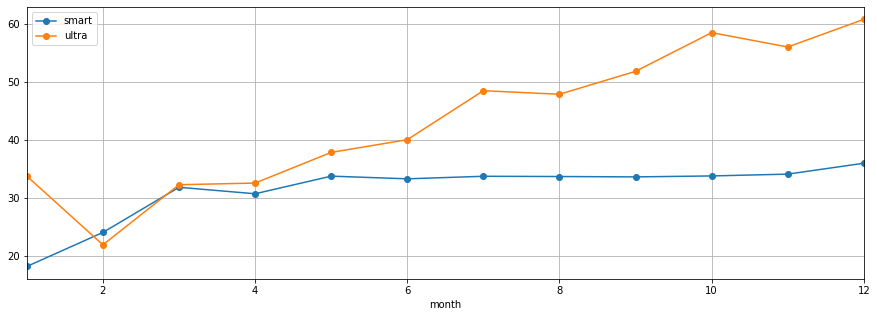

In [59]:
ax1 = (smart_users_mess
 .plot(style='o-', figsize=(15,5), grid=True)
 )
(ultra_users_mess
 .plot(style='o-', figsize=(15,5), grid=True, ax=ax1, )
 )
plt.legend(['smart', 'ultra'])

**ultra** стремительно растет, **smart** не сильно изменяется.

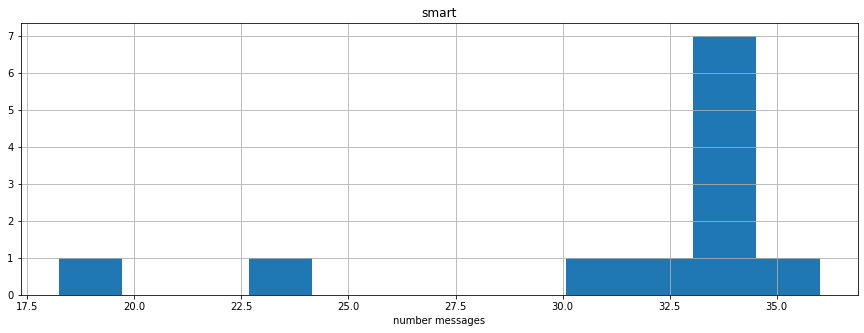

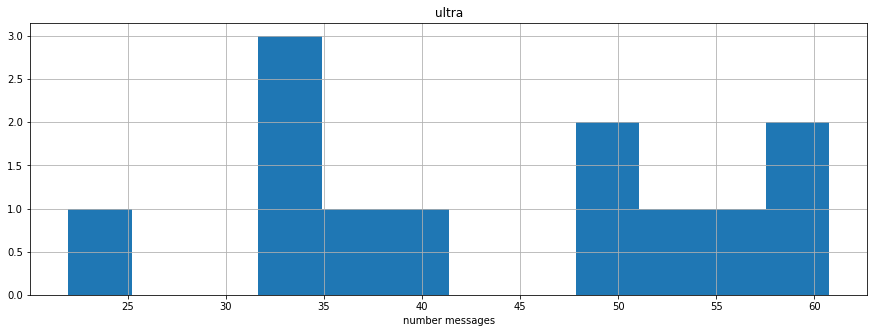

In [60]:
(smart_users_mess
     .hist(figsize=(15,5), bins=12)
)
plt.title('smart')
plt.xlabel('number messages')
plt.show()
(ultra_users_mess
     .hist(figsize=(15,5), bins=12)
)
plt.title('ultra')
plt.xlabel('number messages')
plt.show()

Чаще всего в месяц завтрачивают 33 сообщения пользователи тарифа **smart**. Про пользователей тарифа **ultra** ситуация сложнее, но в целом, тоже  32-33 сообщения

### Какой объем интренет-трафика требуется пользователям в месяц?

Для тарифа "smart"

In [61]:
smart_users_internet = (users_data
                        .query('tariff == "smart"')
                        .groupby('month')['mb_used']
                        .mean()
                       )
smart_users_internet

month
1      8513.717647
2     11597.054310
3     15104.159091
4     13462.180625
5     15805.184326
6     15815.210982
7     15743.150348
8     16634.481453
9     16300.093398
10    16747.558669
11    16893.805016
12    18116.016667
Name: mb_used, dtype: float64

Посчитаем среднее

In [62]:
smart_users_internet.mean()

15061.051044297014

Посчитаем дисперсию и стандартное отклонение для выборки

In [63]:
np.var(smart_users_internet, ddof=1)

7141805.742568948

In [64]:
np.sqrt(np.var(smart_users_internet, ddof=1))

2672.4157129026444

Среднее отклонение тарифа **smart** - 2672

Для тарифа **ultra**

In [65]:
ultra_users_internet = (users_data
                        .query('tariff == "ultra"')
                        .groupby('month')['mb_used']
                        .mean()
                       )
ultra_users_internet

month
1     13140.681111
2     11775.937500
3     17535.550270
4     17397.983396
5     19674.937188
6     18908.840123
7     20447.021136
8     19591.885437
9     19094.427117
10    20074.337966
11    19640.684806
12    21693.903284
Name: mb_used, dtype: float64

Посчитаем среднее

In [66]:
ultra_users_internet.mean()

18248.01577790199

Посчитаем среднее и дисперсию для выборки

In [67]:
np.var(ultra_users_internet)

8015230.262462791

In [68]:
np.sqrt(np.var(ultra_users_internet))

2831.118200016169

Среднее отклонение тарифа **ultra** - 2831

Построим график:

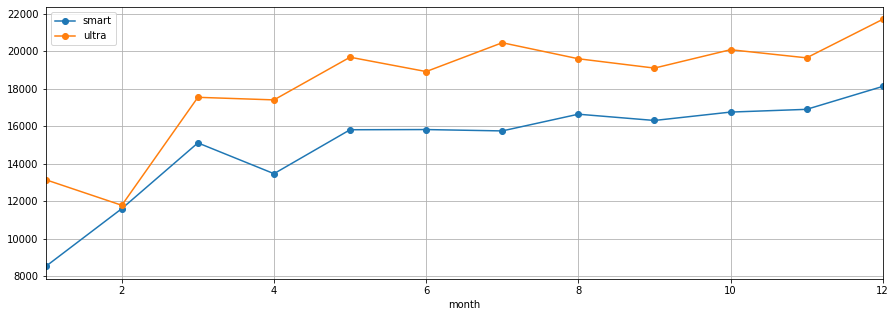

In [69]:
ax1 = (smart_users_internet
 .plot(style='o-', figsize=(15,5), grid=True)
 )
(ultra_users_internet
 .plot(style='o-', figsize=(15,5), grid=True, ax=ax1, )
 )
plt.legend(['smart', 'ultra'])

Средние отклонения похожи, что и подтверждает график

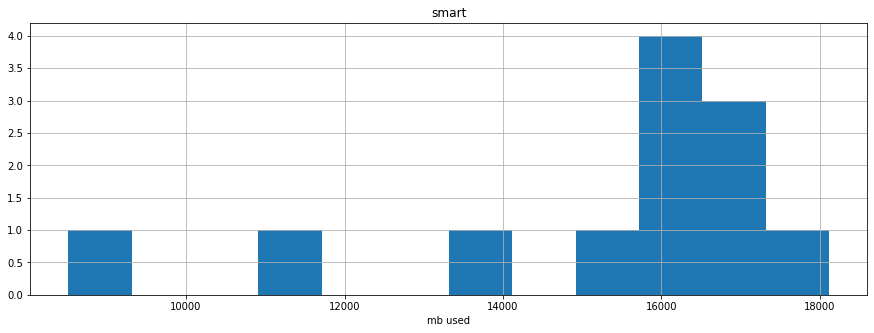

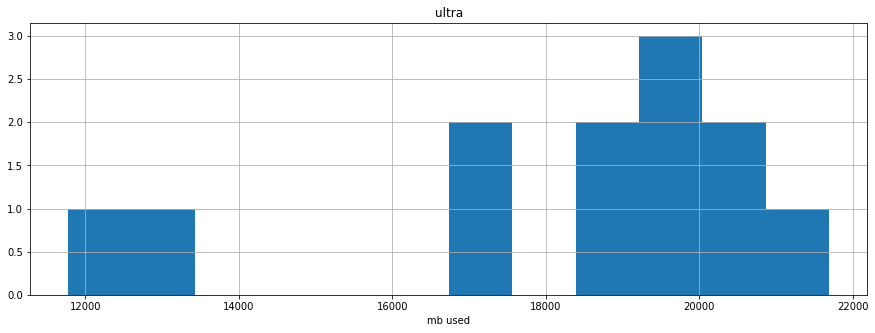

In [70]:
(smart_users_internet
     .hist(figsize=(15,5), bins=12)
)
plt.title('smart')
plt.xlabel('mb used')
plt.show()
(ultra_users_internet
     .hist(figsize=(15,5), bins=12)
)
plt.title('ultra')
plt.xlabel('mb used')
plt.show()

Пользователи тарифа **smart**  чаще всего тратят 16000 мегабайт интернета (при данных 15000!), т.е люди часто докупают дополнительные пакеты.

Пользователи тарифа **ultra** чаще всего тратят 19000-20000 мегабайт ежемесячно (при норме 30000), т.е люди практически не докупают дополнительные мегабайты.

## Вывод

Мы изучили потребности пользователей двух тарифов: сколько минут разговора, сообщений и интернет трафика требуется пользователям.

## Шаг 4. Проверка гипотиз

Даны гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


Посчитаем вариацию для выборки по выручке для людей, иcпользующих тариф **ultra**

In [71]:
np.var(users_data.query('tariff == "ultra"')['revenue'], ddof=1)

128285.84765952737

Посмотрим на гистограмму:

(1900, 4000)

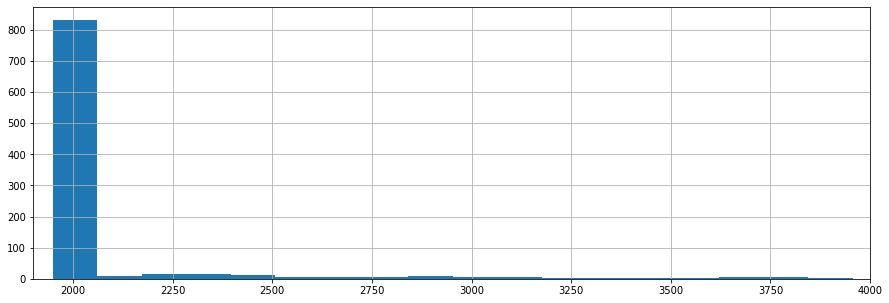

In [72]:
users_data.query('tariff == "ultra"')['revenue'].hist(bins=25, figsize=(15,5))
plt.xlim(1900, 4000)

Распределение не является нормальным

Посчитаем вариацию для выборки по выручке для людей, иcпользующих тариф **smart**

In [73]:
np.var(users_data.query('tariff == "smart"')['revenue'], ddof=1)

590682.1285990948

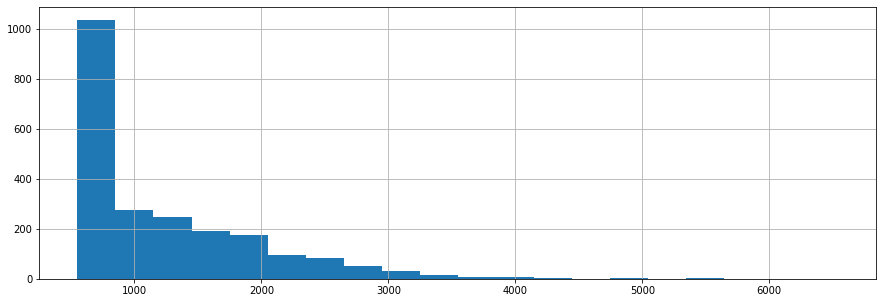

In [74]:
users_data.query('tariff == "smart"')['revenue'].hist(bins=20, figsize=(15,5))

Распределения не являются нормальными, дисперсии сильно различаются, они независимые, следовательно критерий Стьюдента для проверки гипотез не подоходит.

Воспользуемся критерием Манна-Уитни

Сделаем предположение H0: "средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова", тогда предположение H1:
"средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

Установим уровень статистической значимости на 5%

In [75]:
whats_p = st.mannwhitneyu(users_data
                .query('tariff == "ultra"')['revenue'],
                users_data
                .query('tariff == "smart"')['revenue']).pvalue
if whats_p > 0.05:
    print(whats_p, 'Не удалось опровергнуть H0')
else:
    print(whats_p, 'H0 опровергнута')

1.1786216021390796e-225 H0 опровергнута


**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

Выделим доход с москвичей

In [76]:
moscow_revenue = users_data.query('city == "Москва"')['revenue']
moscow_revenue

8       1150
9        550
17      1950
18      1950
19      1950
        ... 
3126     925
3127     550
3128    1587
3129    1205
3130     634
Name: revenue, Length: 610, dtype: int64

Посчитаем вариацию по выборке

In [77]:
np.var(moscow_revenue, ddof=1)

544730.7456593717

Выделим доход с НЕ москвичей

In [78]:
other_revenue = users_data[~(users_data['city'] == 'Москва')]['revenue']
other_revenue

0       1950
1       1950
2       1950
3       1950
4       1950
        ... 
3177    1570
3178     550
3179    1025
3180    1316
3181     598
Name: revenue, Length: 2564, dtype: int64

Посчитаем вариацию по выборке

In [79]:
np.var(other_revenue, ddof=1)

623069.3096907997

Изобразим гистограммы

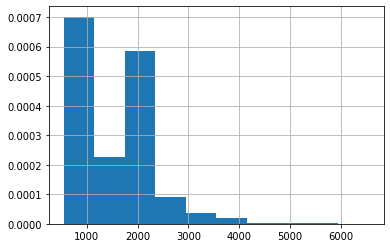

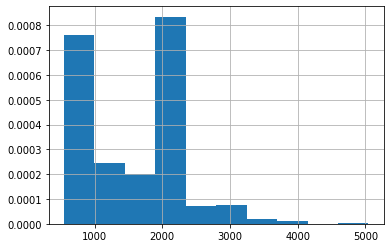

In [80]:
other_revenue.hist(density=True)
plt.show()
moscow_revenue.hist(density=True)
plt.show()

Распределения не являются нормальными, дисперсии сильно различаются, данные независимые.

Применим критерий Манна-Уитни

Гипотеза H0: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
Гипотеза H1: средние выручки различаются

Установим размер статистической значимости на 5%

In [81]:
whats_p2 = st.mannwhitneyu(moscow_revenue, other_revenue).pvalue
if whats_p2 > 0.05:
    print(whats_p2, 'Не удалось опровергнуть гипотезу H0')
else:
    print(whats_p2, 'Гипотеза H0 опровергнута')

0.08491536889612289 Не удалось опровергнуть гипотезу H0


**Средние выручки с проживающих в Москве и остальных НЕ различаются**

### Вывод

Проверили две гипотезы, основываясь на критерий Манна-Уитни и получили следующие результаты:
- **Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**
- **Средние выручки с проживающих в Москве и остальных НЕ различаются**

## Шаг 5. Общий вывод

В результате были предобработаны данные, составлен "глобальный" датасет, изучены тарифные планы **smart** и **ultra** и проверены поставленные перед нами гипотезы.

В целом, получили, что за тариф **smart** многие люди плятят дополнительно из-за того, что им не хватает или интернета, или сообщений, или звонков. За тариф **ultra** напротив, практически не переплачивают.

Видимо поэтому тариф и назвается smart (от англ. "умный"). Будь умным, чтобы не переплатить.